# CIS 5450 Final Project

Dataset: https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

In [23]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Load datasets
prices = pd.read_csv(
    "./datasets/stock_prices_latest.csv",
    parse_dates=["date"],
    dtype={"symbol": str}
)
earnings = pd.read_csv(
    "./datasets/earnings_latest.csv",
    parse_dates=["date"],
    dtype={"symbol": str, "announce_time": str}
)

In [16]:
display(earnings.columns)
display(prices.columns)

Index(['symbol', 'date', 'qtr', 'eps_est', 'eps', 'release_time'], dtype='object')

Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume', 'split_coefficient'],
      dtype='object')

# Cleaning Dataset

In [17]:
# Rename Columns
earnings = earnings.rename(
    columns={
        "date": "earnings_date",
        "eps_est": "consensus_eps",
        "eps": "actual_eps",
        "release_time": "announce_time"
    }
)
display(earnings.columns)

Index(['symbol', 'earnings_date', 'qtr', 'consensus_eps', 'actual_eps',
       'announce_time'],
      dtype='object')

In [18]:
# Drop events missing EPS or announcement time
earnings = earnings.dropna(
    subset=["consensus_eps", "actual_eps", "announce_time"]
).reset_index(drop=True)

# Compute the effective trading date of the event
def effective_trade_date(row):
    # After Market Close (AMC) → next trading day; Before Market Open (BMO) → same day
    if row["announce_time"].upper().startswith("AMC"):
        return row["earnings_date"] + pd.Timedelta(days=1)
    else:
        return row["earnings_date"]

earnings["trade_date"] = earnings.apply(effective_trade_date, axis=1)

In [19]:
# Restrict price data to the relevant date span (±5 days around events)
min_date = earnings["trade_date"].min() - pd.Timedelta(days=5)
max_date = earnings["trade_date"].max() + pd.Timedelta(days=5)
prices = prices[
    (prices["date"] >= min_date) &
    (prices["date"] <= max_date)
].copy()

# Keep only adjusted prices to handle splits/dividends
prices = prices[[
    "symbol", "date", "close_adjusted", "open", "high", "low", "volume"
]]

# Merge earnings events with price data on effective trade date
event_prices = pd.merge(
    earnings[["symbol", "earnings_date", "trade_date", "actual_eps", "consensus_eps"]],
    prices,
    left_on=["symbol", "trade_date"],
    right_on=["symbol", "date"],
    how="inner"
)

# Drop duplicates and reset index
event_prices = event_prices.drop_duplicates(subset=["symbol", "earnings_date"]).reset_index(drop=True)

# Save cleaned data for downstream analysis
event_prices.to_csv("cleaned_event_price_data.csv", index=False)

# Display the shape of the cleaned dataset
event_prices.shape

(79444, 11)

# EDA

In [27]:
df = pd.read_csv("cleaned_event_price_data.csv", parse_dates=["earnings_date", "trade_date", "date"])

# Compute earnings surprise and event-day return
df['surprise'] = df['actual_eps'] - df['consensus_eps']
df['return'] = (df['close_adjusted'] - df['open']) / df['open']

# Create a binary indicator for beat vs. miss
df['beat'] = df['surprise'] > 0

# Extract the year of each earnings date
df['year'] = df['earnings_date'].dt.year

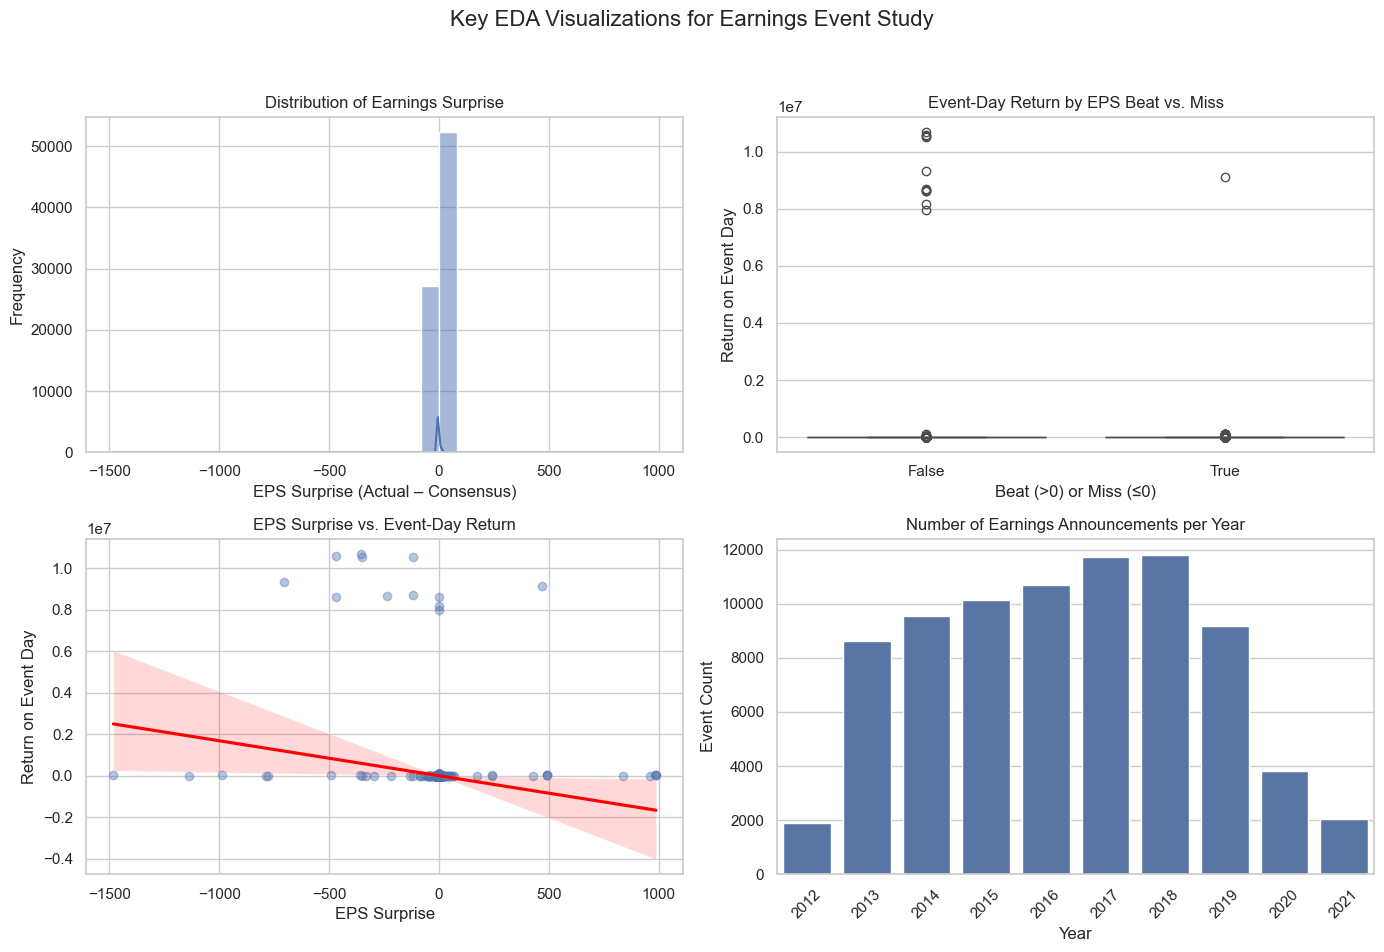

In [28]:
# Set Seaborn style
sns.set(style="whitegrid")

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Key EDA Visualizations for Earnings Event Study", fontsize=16)

# 1. Distribution of Earnings Surprise
sns.histplot(data=df, x='surprise', bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Earnings Surprise")
axes[0, 0].set_xlabel("EPS Surprise (Actual – Consensus)")
axes[0, 0].set_ylabel("Frequency")

# 2. Boxplot: Event-Day Return by Beat vs. Miss
sns.boxplot(data=df, x='beat', y='return', ax=axes[0, 1])
axes[0, 1].set_title("Event-Day Return by EPS Beat vs. Miss")
axes[0, 1].set_xlabel("Beat (>0) or Miss (≤0)")
axes[0, 1].set_ylabel("Return on Event Day")

# 3. Scatter with Regression: Surprise vs. Event-Day Return
sns.regplot(data=df, x='surprise', y='return', scatter_kws={'alpha':0.4}, line_kws={'color':'red'}, ax=axes[1, 0])
axes[1, 0].set_title("EPS Surprise vs. Event-Day Return")
axes[1, 0].set_xlabel("EPS Surprise")
axes[1, 0].set_ylabel("Return on Event Day")

# 4. Count of Earnings Events per Year
sns.countplot(data=df, x='year', ax=axes[1, 1])
axes[1, 1].set_title("Number of Earnings Announcements per Year")
axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Event Count")
for label in axes[1, 1].get_xticklabels():
    label.set_rotation(45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()